In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

We will first download the Dataset

In [ ]:
BATCH_SIZE=32

# transformation
transform=transforms.Compose([transforms.ToTensor()])

#download and load the traninig data
trainset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

#download and load the test data
testset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 274401779.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35399092.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71313288.41it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21050308.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(len(testset))
print(testset[0])

60000
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
      super(MyModel,self).__init__()

      self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
      self.d1=nn.Linear(26*26*32,128)
      self.d2=nn.Linear(128,10)

    def forward(self,x):
      x=self.conv1(x)
      x=F.relu(x)

      x=x.flatten(start_dim=1)

      x=self.d1(x)
      x=F.relu(x)

      logits=self.d2(x)
      out=F.softmax(logits,dim=1)
      return out

In [ ]:
import numpy as np
a=np.array([[1,2],[3,4]])
b=np.ones((2,2))
print(np.matmul(a,b))

ta=torch.tensor(a,dtype=float).to('cuda:0')
tb=torch.ones(2,2,dtype=float).to('cuda:0')
print(tb)
print(ta)
print(torch.matmul(ta,tb))
print(torch.cuda.is_available())


[[3. 3.]
 [7. 7.]]
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', dtype=torch.float64)
tensor([[1., 2.],
        [3., 4.]], device='cuda:0', dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], device='cuda:0', dtype=torch.float64)
True


Training the Model

In [ ]:
learning_rate=0.001
num_epochs=5

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model=MyModel()
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range (num_epochs):
  train_running_loss=0.0
  train_acc=0.0

  for i,(images,labels) in enumerate(trainloader):

    images=images.to(device)
    labels=labels.to(device)

    logits=model(images)
    loss=criterion(logits,labels)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    train_running_loss+=loss.detach().item()
    train_acc+=(torch.argmax(logits,1).flatten()==labels).type(torch.float).mean().item()

  print('Epoch : %d | Loss=  %.4f | Train Accuracy=%.2f' \
        %(epoch,train_running_loss/(i+1), train_acc/(i+1)))




Epoch : 0 | Loss=  1.4674 | Train Accuracy=0.99
Epoch : 1 | Loss=  1.4664 | Train Accuracy=0.99
Epoch : 2 | Loss=  1.4662 | Train Accuracy=1.00
Epoch : 3 | Loss=  1.4661 | Train Accuracy=1.00
Epoch : 4 | Loss=  1.4660 | Train Accuracy=1.00


Lastly we can run the forward pass on the test_set

In [ ]:
from sklearn.metrics import precision_score
test_acc=0.0
for i, (images,labels) in enumerate(testloader,0):
  images=images.to(device)
  labels=labels.to(device)
  output=model(images)
  test_acc +=(torch.argmax(output,1).flatten() ==labels).type(torch.float).mean().item()
  preds=torch.argmax(output,1).flatten().cpu().numpy()
  l=labels.cpu().numpy()


print(test_acc/(i+1))

0.9955833333333334


Set Up

In [ ]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.0 MB/s eta 0:00:00
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info
  writing /tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/SOURCES.txt'
  reading manifest template 'MANIFEST.in'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-1mk9s_ve/torch_scatter.egg-info/SOURCE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torch-geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
!pip install tensorboardX
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.6 MB/s eta 0:00:00


Defining the Model

In [ ]:
class GNNStack(nn.Module):
  def __init__ (self,input_dim,hidden_dim,output_dim,task='node'):
    super(GNNStack,self).__init__()
    self.task=task
    self.convs=nn.ModuleList()
    self.convs.append(self.build_conv_model(input_dim,hidden_dim))
    for l in range (2):
      self.convs.append(self.build_conv_model(hidden_dim,hidden_dim))
    self.dropout=0.25
    self.num_layers=3
    self.post_mp=nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.Dropout(0.25),nn.Linear(hidden_dim,output_dim))



  def build_conv_model(self,input_dim,hidden_dim):
    if self.task=='node':
      return Custom_Conv(input_dim,hidden_dim)
    else:
      return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,hidden_dim)))

  def forward(self,data):
    x,edge_index,batch=data.x,data.edge_index,data.batch
    if data.num_node_features==0:
      x=torch.ones(data.num_nodes,1)

    for i in range (0,self.num_layers):
      x=self.convs[i](x,edge_index)
      emb=x
      x=F.relu(x)
      x=F.dropout(x,p=self.dropout,training=self.training)

    if self.task=='graph':
      x=pyg_nn.global_mean_pool(x,batch)
    x=self.post_mp(x)

    return(emb,F.log_softmax(x,dim=1))

  def loss(self,pred,label):
    return (F.nll_loss(pred,label))

In [ ]:
class Custom_Conv(pyg_nn.MessagePassing):
  def __init__ (self,in_channels,out_channels):
    super(Custom_Conv,self).__init__(aggr='add')
    self.lin=nn.Linear(in_channels,out_channels)
    self.lin_self=nn.Linear(in_channels,out_channels)

  def forward(self,x,edge_index):
    #x has shape [n,in_channels]
    #edge has shape[2,E]

    #Add self loop to the adjancey matrix
    edge_index,_=pyg_utils.remove_self_loops(edge_index)
    self_x=self.lin_self(x)

    return self_x + self.propagate(edge_index,size=(x.size(0),x.size(0)),x=self.lin(x))

  def message(self,x_j,edge_index,size):
    row,col=edge_index
    deg= pyg_utils.degree(row,size[0], dtype=x_j.dtype)
    deg_inv_sqrt=deg.pow(-0.5)
    norm=deg_inv_sqrt[row]*deg_inv_sqrt[col]
    return x_j

  def update(self,aggr_out):
    F.normalize()
    return aggr_out

Train the Model

In [ ]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)

    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model


In [ ]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]

        correct += pred.eq(label).sum().item()

    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

Training the Dataset

In [ ]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format("./log")
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 1.9583. Test accuracy: 0.1880
Epoch 10. Loss: 0.2373. Test accuracy: 0.7310
Epoch 20. Loss: 0.0504. Test accuracy: 0.7280
Epoch 30. Loss: 0.0257. Test accuracy: 0.7400
Epoch 40. Loss: 0.0319. Test accuracy: 0.7240
Epoch 50. Loss: 0.0042. Test accuracy: 0.7400
Epoch 60. Loss: 0.0153. Test accuracy: 0.7350
Epoch 70. Loss: 0.0249. Test accuracy: 0.7470
Epoch 80. Loss: 0.0105. Test accuracy: 0.7370
Epoch 90. Loss: 0.0028. Test accuracy: 0.7500
Epoch 100. Loss: 0.0104. Test accuracy: 0.7240
Epoch 110. Loss: 0.0301. Test accuracy: 0.7540
Epoch 120. Loss: 0.0024. Test accuracy: 0.7620
Epoch 130. Loss: 0.0059. Test accuracy: 0.7350
Epoch 140. Loss: 0.0047. Test accuracy: 0.7110
Epoch 150. Loss: 0.0105. Test accuracy: 0.7230
Epoch 160. Loss: 0.1169. Test accuracy: 0.7300
Epoch 170. Loss: 0.0146. Test accuracy: 0.7600
Epoch 180. Loss: 0.0016. Test accuracy: 0.7440
Epoch 190. Loss: 0.0036. Test accuracy: 0.7620


Visualising the Node Embedding

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


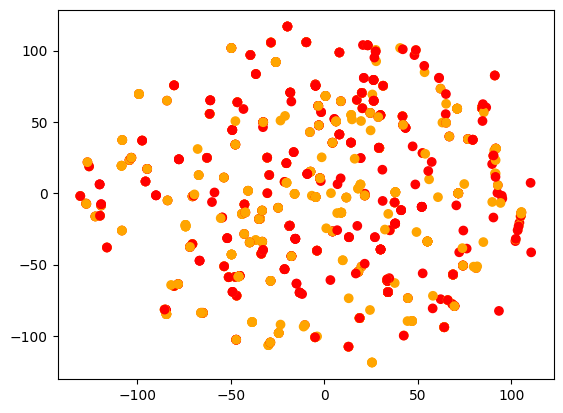

In [104]:
color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)


xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
xs = xs[:1000]
ys = ys[:1000]
plt.scatter(xs, ys, color=colors)